# Analyzing cell type resolved RNA expression of significantly differentially expressed proteins in the sinus node using Linscheid et al. 2019 snRNAseq data set

Author: Konstantin Kahnert

Data from https://doi.org/10.1038/s41467-019-10709-9 Supplementary data 6

## Load required libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

## Define required functions

In [2]:
def save_figure(fig, name, folder_output):

    # create new path name for saving the figure as pdf
    path_fig = folder_output + "\\" + name + ".pdf"

    # save figure
    plt.savefig(path_fig, bbox_inches="tight")

    # create new path name for saving the figure as png
    path_fig = folder_output + "\\" + name + ".png"

    # save figure
    plt.savefig(path_fig, bbox_inches="tight", dpi=600)

    return None

# Load data

In [3]:
folder_output = r"E:\Data\Heart_failure_mice_CS\Sinus_node\Transcriptomics"

# load mean transcript numbers per cell type from Nora's paper
path_paper_S2 = r"E:\Data\Sinus_node_paper_Nora\Supplementary_info_6_mean_transcripts.xlsx"
df_transcripts_paper = pd.read_excel(io=path_paper_S2, sheet_name="avg.expr")

# order columns
column_order = ["gene", "Adipocytes I", "Adipocytes II", "Adipocytes III", "Endocardial cells", "Epicardial cells", "Epithelial cells", "Fibroblasts I", "Fibroblasts II", "Macrophages", "Neurons", "Sinus node myocytes", "Vascular endothelial cells"]
df_transcripts_paper = df_transcripts_paper[column_order]

df_transcripts_paper.shape


(27998, 13)

In [4]:
# load singificantly differentially expressed proteins in HF in SN
path_signif_SN = r"E:\Data\Heart_failure_mice_CS\Sinus_node\Proteome\Analysis\canonical\w_PIF\03_diff_expr_analysis\df_proteingroups_log_median subtraction_norm _empBayes_pvals_vp.xlsx"

df_signif_SN_up = pd.read_excel(io=path_signif_SN, sheet_name="signif. increased")
df_signif_SN_down = pd.read_excel(io=path_signif_SN, sheet_name="signif. decreased")

# Remove genes with 0 mean expression value in all cell types

In [5]:
df_transcripts_paper = df_transcripts_paper[df_transcripts_paper.sum(axis=1) != 0]
df_transcripts_paper.shape

(21020, 13)

In [6]:
df_transcripts_paper.head(5)

,gene,Adipocytes I,Adipocytes II,Adipocytes III,Endocardial cells,Epicardial cells,Epithelial cells,Fibroblasts I,Fibroblasts II,Macrophages,Neurons,Sinus node myocytes,Vascular endothelial cells
0,Xkr4,0.234756,0.254808,0.680445,0.212851,2.059060,1.680380,1.016973,0.870130,0.373134,1.758170,0.670659,0.281640
1,Gm1992,0.000000,0.000000,0.011129,0.000000,0.012081,0.003165,0.004243,0.008658,0.000000,0.000000,0.007485,0.000000
2,Gm37381,0.003049,0.000000,0.001590,0.008032,0.005369,0.003165,0.000000,0.004329,0.014925,0.003268,0.124251,0.001783
3,Rp1,0.024390,0.040865,0.031797,0.036145,0.051007,0.034810,0.025460,0.064935,0.084577,0.029412,1.175150,0.033868
5,Sox17,0.006098,0.009615,0.027027,0.012048,0.008054,0.006329,0.008487,0.012987,0.004975,0.009804,0.047904,0.035651


## Z-normalize mean transcription data

In [7]:
# set gene names as index for transcript data
df_transcripts_paper = df_transcripts_paper.set_index("gene")
#df_transcripts = df_transcripts - df_transcripts.median()

# z-normalize count data
scaler = StandardScaler()
df_transcripts_paper_z = scaler.fit_transform(df_transcripts_paper.T)
df_transcripts_paper_z = pd.DataFrame(data=df_transcripts_paper_z, index=df_transcripts_paper.T.index, 
                                      columns=df_transcripts_paper.T.columns)

# get transcript counts for upregularted proteins
df_transcripts_paper_up_z = df_transcripts_paper_z.T[df_transcripts_paper_z.T.index.isin(df_signif_SN_up["Gene names"])].T

# get transcript counts for downregularted proteins
df_transcripts_paper_down_z = df_transcripts_paper_z.T[df_transcripts_paper_z.T.index.isin(df_signif_SN_down["Gene names"])].T



## Sort genes by highest expression for each cell type using 2 STDs as cutoff

In [8]:
# split data by expression >= 2.5 in any cell type and expression < 2.5 in all cell types
df_transcripts_up_z_high = df_transcripts_paper_up_z.T[(df_transcripts_paper_up_z.T >= 2).any(axis=1)]
df_transcripts_up_z_low = df_transcripts_paper_up_z.T[(df_transcripts_paper_up_z.T < 2).all(axis=1)]

df_transcripts_down_z_high = df_transcripts_paper_down_z.T[(df_transcripts_paper_down_z.T >= 2).any(axis=1)]
df_transcripts_down_z_low = df_transcripts_paper_down_z.T[(df_transcripts_paper_down_z.T < 2).all(axis=1)]

# sort by one column after another by decending values starting with the first and extract all genes 
# with values >= 2.5 for the sorted column
genes_sorted = []
for column in df_transcripts_up_z_high.columns:
    df_transcripts_up_z_high.sort_values(by=column, inplace=True, ascending=False)
    genes_high = list(df_transcripts_up_z_high[df_transcripts_up_z_high[column] >= 2].index)
    for i in genes_high:
        genes_sorted.append(i)
    df_transcripts_up_z_high.drop(genes_high)    

df_transcripts_up_z_high_sorted = df_transcripts_up_z_high.T[genes_sorted]

genes_sorted = []
for column in df_transcripts_down_z_high.columns:
    df_transcripts_down_z_high.sort_values(by=column, inplace=True, ascending=False)
    genes_high = list(df_transcripts_down_z_high[df_transcripts_down_z_high[column] >= 2].index)
    for i in genes_high:
        genes_sorted.append(i)
    df_transcripts_down_z_high.drop(genes_high)    

df_transcripts_down_z_high_sorted = df_transcripts_down_z_high.T[genes_sorted]




## Count genes with expression z score > 2 per cell type and visualize as bar plot

In [9]:
counts_all = (df_transcripts_paper_z.T > 2).sum()
counts_all.sort_values(ascending=False, inplace=True)
counts_all

Sinus node myocytes           3738
Fibroblasts II                1872
Adipocytes III                1460
Macrophages                   1330
Adipocytes II                 1024
Neurons                        835
Adipocytes I                   791
Epithelial cells               773
Epicardial cells               542
Fibroblasts I                  479
Endocardial cells              340
Vascular endothelial cells     299
dtype: int64

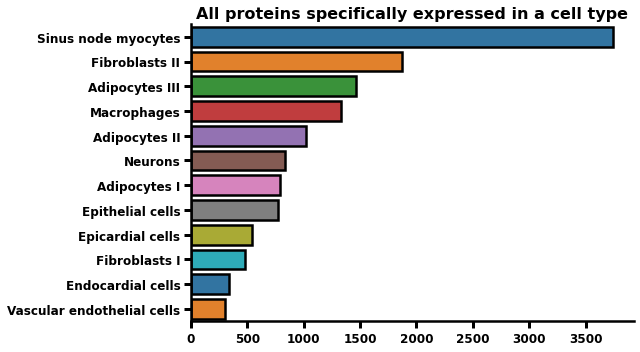

In [10]:
fig, ax = plt.subplots(figsize=(9, 5))
sns.barplot(x = counts_all, y = counts_all.index, palette="tab10", edgecolor="black", linewidth=2.5)
plt.title("All proteins specifically expressed in a cell type", fontsize=16, fontweight="bold")
ax.tick_params(axis='both', which='major', labelsize=12, size=7, width=3)
plt.xticks(weight = 'bold')
plt.yticks(weight = 'bold')

for axis in ['bottom','left']:
  ax.spines[axis].set_linewidth(2.5)

for axis in ['top', 'right']:
  ax.spines[axis].set_linewidth(0)

plt.tight_layout()
# save figure
name = "Comparison_to_SN_snRNAseq_cluster_specific_genes_all"
save_figure(fig, name, folder_output)

## Plot z-scored RNA expression of singificantly upregulated proteins (based on proteome data) that have a z score > 2 

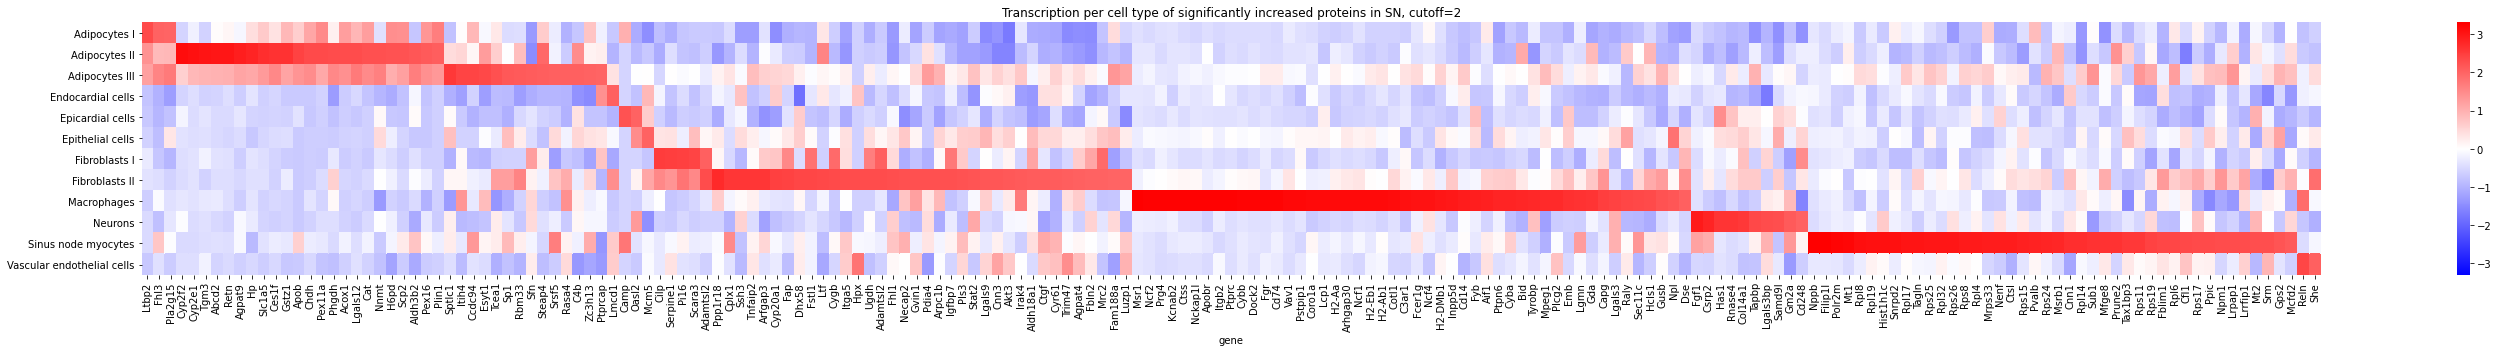

In [11]:
fig, ax = plt.subplots(figsize=(40, 5))
sns.heatmap(df_transcripts_up_z_high_sorted, cmap="bwr", ax=ax,
            xticklabels=df_transcripts_up_z_high_sorted.columns, yticklabels=df_transcripts_up_z_high_sorted.index, 
            vmin=-df_transcripts_up_z_high_sorted.max().max(), vmax=df_transcripts_up_z_high_sorted.max().max())
plt.title("Transcription per cell type of significantly increased proteins in SN, cutoff=2")
plt.tight_layout()

# save figure
name = "transcripts_nora_of_signif_proteins_SN_increased_heatmap_sorted_2cutoff"
save_figure(fig, name, folder_output)


## Count significantly upregulated proteins with RNA expression z score > 2 per cell type and visualize as bar plot

In [12]:
# Count singificantly upregulated proteins (based on proteome data) that have a z score > 2 for each cell type 
counts = (df_transcripts_up_z_high > 2).sum()
counts.sort_values(ascending=False, inplace=True)
counts

Macrophages                   48
Sinus node myocytes           42
Fibroblasts II                36
Adipocytes II                 23
Adipocytes III                14
Neurons                       10
Fibroblasts I                  5
Adipocytes I                   3
Epicardial cells               2
Vascular endothelial cells     2
Endocardial cells              1
Epithelial cells               1
dtype: int64

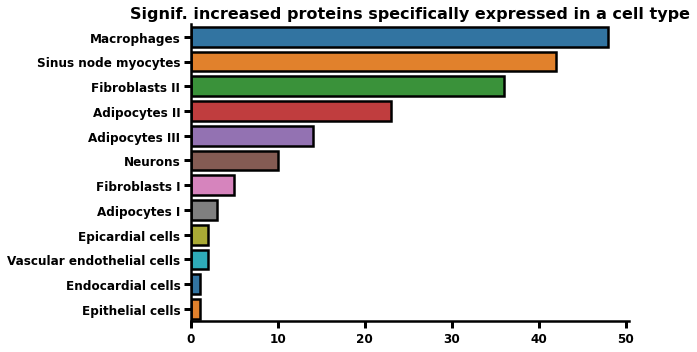

In [13]:
fig, ax = plt.subplots(figsize=(9, 5))
sns.barplot(x = counts, y = counts.index, palette="tab10", edgecolor="black", linewidth=2.5)
plt.title("Signif. increased proteins specifically expressed in a cell type", fontsize=16, fontweight="bold")
ax.tick_params(axis='both', which='major', labelsize=12, size=7, width=3)
plt.xticks(weight = 'bold')
plt.yticks(weight = 'bold')

for axis in ['bottom','left']:
  ax.spines[axis].set_linewidth(2.5)

for axis in ['top', 'right']:
  ax.spines[axis].set_linewidth(0)

plt.tight_layout()

# save figure
name = "Comparison_to_SN_snRNAseq_cluster_specific_genes_incr_prot"
save_figure(fig, name, folder_output)

# Normalized by "specificity"  
  
i.e. divide by the number of specifically expressed genes per cell type based on all gene in whole snRNAseq data set

In [14]:
counts_norm = counts / counts_all * 100
counts_norm.sort_values(ascending=False, inplace=True)
counts_norm

Macrophages                   3.609023
Adipocytes II                 2.246094
Fibroblasts II                1.923077
Neurons                       1.197605
Sinus node myocytes           1.123596
Fibroblasts I                 1.043841
Adipocytes III                0.958904
Vascular endothelial cells    0.668896
Adipocytes I                  0.379267
Epicardial cells              0.369004
Endocardial cells             0.294118
Epithelial cells              0.129366
dtype: float64

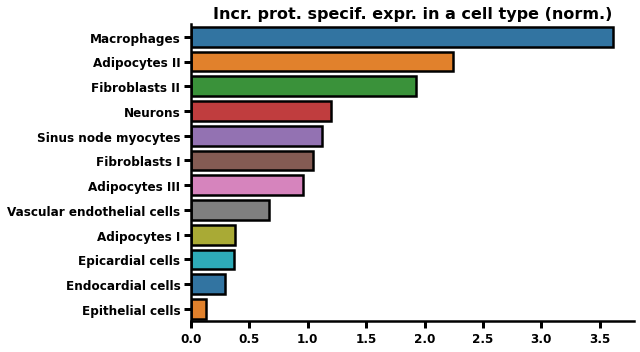

In [15]:
fig, ax = plt.subplots(figsize=(9, 5))
sns.barplot(x = counts_norm, y = counts_norm.index, palette="tab10", edgecolor="black", linewidth=2.5)
plt.title("Incr. prot. specif. expr. in a cell type (norm.)", fontsize=16, fontweight="bold")
ax.tick_params(axis='both', which='major', labelsize=12, size=7, width=3)
plt.xticks(weight = 'bold')
plt.yticks(weight = 'bold')

for axis in ['bottom','left']:
  ax.spines[axis].set_linewidth(2.5)

for axis in ['top', 'right']:
  ax.spines[axis].set_linewidth(0)

plt.tight_layout()

# save figure
name = "Comparison_to_SN_snRNAseq_cluster_specific_genes_incr_prot_norm"
save_figure(fig, name, folder_output)

## Make heatmap of macrophage specific genes (that are signif. upregulated in HF)

In [16]:
df_transcripts_macrophage_specific = df_transcripts_up_z_high[df_transcripts_up_z_high["Macrophages"] > 2]
df_transcripts_macrophage_specific.sort_values(ascending=False, inplace=True, by="Macrophages")

C:\Users\zlj638\AppData\Local\Continuum\anaconda3\envs\MS_data_analysis_pipeline\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


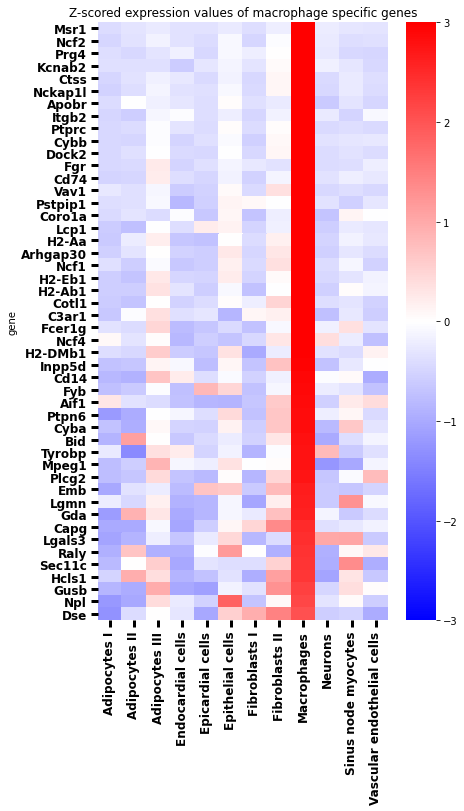

In [17]:
fig, ax = plt.subplots(figsize=(6.5, 11))
sns.heatmap(df_transcripts_macrophage_specific, cmap="bwr", ax=ax,
            xticklabels=df_transcripts_macrophage_specific.columns, yticklabels=df_transcripts_macrophage_specific.index, 
            vmin=-3, vmax=3, cbar_kws = dict(use_gridspec=False,location="right"))
plt.title("Z-scored expression values of macrophage specific genes")
ax.tick_params(axis='both', which='major', labelsize=12, size=7, width=3)
plt.xticks(weight = 'bold')
plt.yticks(weight = 'bold')
#plt.tight_layout()

# save figure
name = "transcripts_nora_of_GWAS_overlap_proteins_macrophage_specific_heatmap"
save_figure(fig, name, folder_output)


## Plot z-scored RNA expression of singificantly downregulated proteins (based on proteome data) that have a z score > 2¶

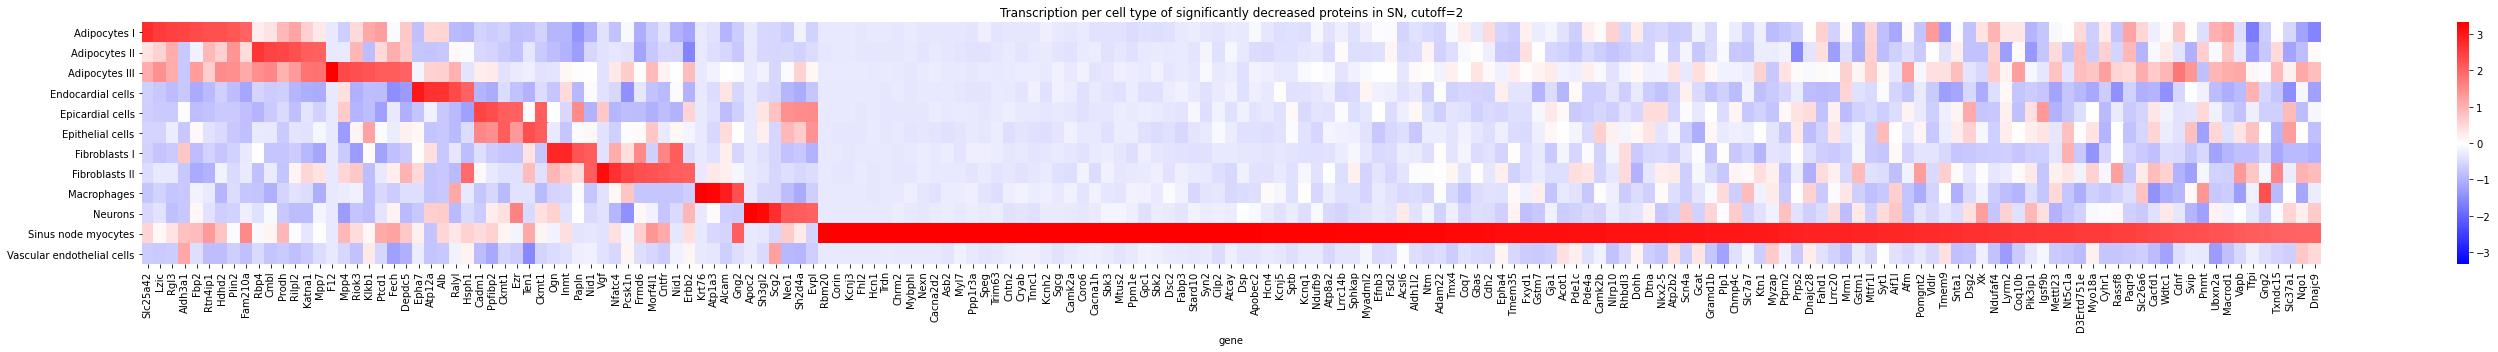

In [18]:
fig, ax = plt.subplots(figsize=(40, 5))
sns.heatmap(df_transcripts_down_z_high_sorted, cmap="bwr", ax=ax,
            xticklabels=df_transcripts_down_z_high_sorted.columns, yticklabels=df_transcripts_down_z_high_sorted.index, 
            vmin=-df_transcripts_down_z_high_sorted.max().max(), vmax=df_transcripts_down_z_high_sorted.max().max())
plt.title("Transcription per cell type of significantly decreased proteins in SN, cutoff=2")
plt.tight_layout()

# save figure
name = "transcripts_nora_of_signif_proteins_SN_decreased_heatmap_sorted_2cutoff"
save_figure(fig, name, folder_output)


## Count significantly downregulated proteins with RNA expression z score > 2 per cell type and visualize as bar plot

In [19]:
counts = (df_transcripts_down_z_high > 2).sum()
counts.sort_values(ascending=False, inplace=True)
counts

Sinus node myocytes           122
Adipocytes I                    9
Fibroblasts II                  8
Adipocytes III                  7
Adipocytes II                   6
Neurons                         6
Endocardial cells               5
Epicardial cells                4
Fibroblasts I                   4
Macrophages                     4
Epithelial cells                2
Vascular endothelial cells      0
dtype: int64

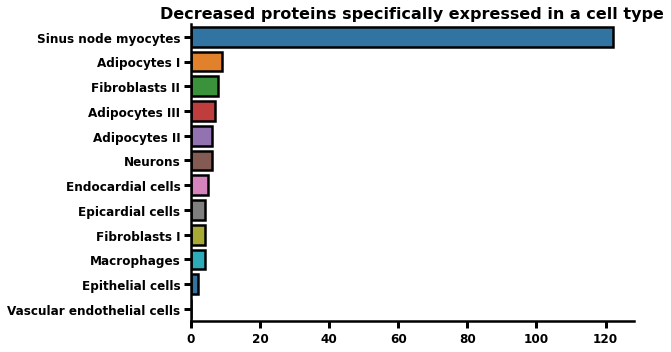

In [20]:
fig, ax = plt.subplots(figsize=(9, 5))
sns.barplot(x = counts, y = counts.index, palette="tab10", edgecolor="black", linewidth=2.5)
plt.title("Decreased proteins specifically expressed in a cell type", fontsize=16, fontweight="bold")
ax.tick_params(axis='both', which='major', labelsize=12, size=7, width=3)
plt.xticks(weight = 'bold')
plt.yticks(weight = 'bold')

for axis in ['bottom','left']:
  ax.spines[axis].set_linewidth(2.5)

for axis in ['top', 'right']:
  ax.spines[axis].set_linewidth(0)

plt.tight_layout()

# save figure
name = "Comparison_to_SN_snRNAseq_cluster_specific_genes_decr_prot"
save_figure(fig, name, folder_output)

# Normalized by "specificity"

In [21]:
counts_norm = counts / counts_all * 100
counts_norm.sort_values(ascending=False, inplace=True)
counts_norm

Sinus node myocytes           3.263777
Endocardial cells             1.470588
Adipocytes I                  1.137800
Fibroblasts I                 0.835073
Epicardial cells              0.738007
Neurons                       0.718563
Adipocytes II                 0.585938
Adipocytes III                0.479452
Fibroblasts II                0.427350
Macrophages                   0.300752
Epithelial cells              0.258732
Vascular endothelial cells    0.000000
dtype: float64

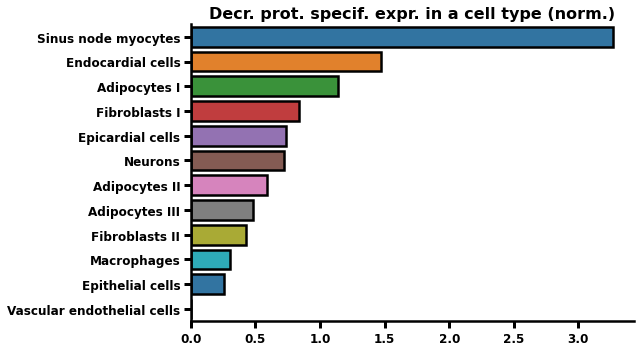

In [22]:
fig, ax = plt.subplots(figsize=(9, 5))
sns.barplot(x = counts_norm, y = counts_norm.index, palette="tab10", edgecolor="black", linewidth=2.5)
plt.title("Decr. prot. specif. expr. in a cell type (norm.)", fontsize=16, fontweight="bold")
ax.tick_params(axis='both', which='major', labelsize=12, size=7, width=3)
plt.xticks(weight = 'bold')
plt.yticks(weight = 'bold')

for axis in ['bottom','left']:
  ax.spines[axis].set_linewidth(2.5)

for axis in ['top', 'right']:
  ax.spines[axis].set_linewidth(0)

plt.tight_layout()
# save figure
name = "Comparison_to_SN_snRNAseq_cluster_specific_genes_decr_prot_norm"
save_figure(fig, name, folder_output)

## Make heatmap of SN myocyte specific genes (that are signif. down regulated in HF)

In [23]:
df_transcripts_myocyte_specific = df_transcripts_down_z_high[df_transcripts_down_z_high["Sinus node myocytes"] > 2]
df_transcripts_myocyte_specific.sort_values(ascending=False, inplace=True, by="Sinus node myocytes")

C:\Users\zlj638\AppData\Local\Continuum\anaconda3\envs\MS_data_analysis_pipeline\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


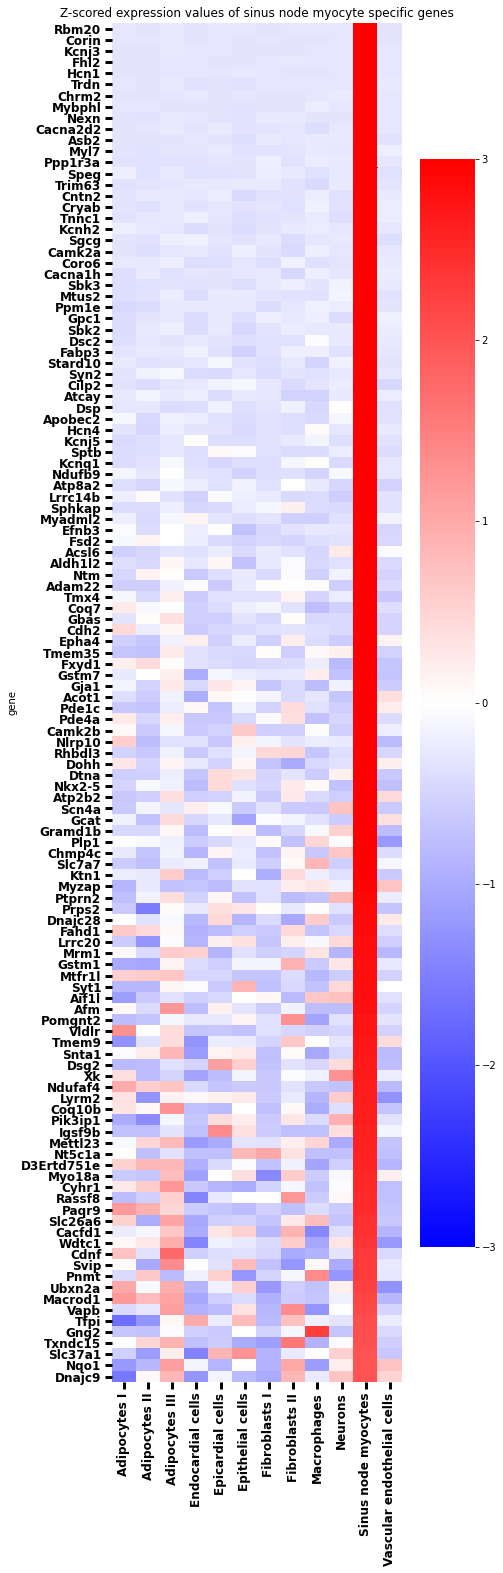

In [24]:
fig, ax = plt.subplots(figsize=(6.5, 25))
sns.heatmap(df_transcripts_myocyte_specific, cmap="bwr", ax=ax,
            xticklabels=df_transcripts_myocyte_specific.columns, yticklabels=df_transcripts_myocyte_specific.index, 
            vmin=-3, vmax=3, cbar_kws = dict(use_gridspec=False,location="right"))
plt.title("Z-scored expression values of sinus node myocyte specific genes")
ax.tick_params(axis='both', which='major', labelsize=12, size=7, width=3)
plt.xticks(weight = 'bold')
plt.yticks(weight = 'bold')
#plt.tight_layout()

# save figure
name = "transcripts_nora_of_GWAS_overlap_proteins_myocyte_specific_heatmap"
save_figure(fig, name, folder_output)


In [25]:
# get number of downregulated proteins expressed mostly in one cell type
(df_transcripts_down_z_high > 2).sum().sum()

177

In [26]:
# get total number of downregulated proteins (with snRNAseq data)
df_transcripts_paper_down_z.shape[1]

230

In [27]:
# get number of upregulated proteins expressed mostly in one cell type
(df_transcripts_up_z_high > 2).sum().sum()

187

In [28]:
# get total number of upregulated proteins (with snRNAseq data)
df_transcripts_paper_up_z.shape[1]

299

# Plot protein fold change of signif. resting heart rate GWAS/signif. proteome overlap 

In [29]:
overlap = ["Cntn2", "Slc26a6", "Kcnh2", "Efnb3", "Nkx2-5", "Dsp", "Hcn1", "Cpne5", "Chrm2", "Rps6ka5", 
           "Cmtm5", "Hcn4", "Kcnj5", "Neo1", "Cdh2", "Tfpi", "Trim63", "Rbm20", "Rilpl2", "Pnmt", "Mettl23", "Cacna2d2", 
           "Tfeb", "Fsd2", "Speg", "Cryab", "Lzic", "Sun2", "Cd34", "Arhgap32", "Arpc1b", "Fkbp7", "Rbm33", "Cd14", 
           "Lmcd1", "Pcolce", "Plvap", "Pi16", "Col4a2", "Snw1", "Mcm7", "Ltbp3", "Itih4", "Abcd2", "Hp", "Serpine1",
           "Rock2", "Cdc42bpa"] # with the two significant kinases (from KSEA + HR GWAS)

df_transcripts_paper_overlap = df_transcripts_paper_z.T[df_transcripts_paper_z.T.index.isin(overlap)]



# sort genes by logfc
df_transcripts_paper_overlap = df_transcripts_paper_overlap.T[overlap].T

# add logFC and spacer column
df_protein_fc = pd.DataFrame({"logFC": [-1.150709126, -0.95196004, -0.89321937, -0.842832193, -0.819840379, -0.727144859, 
                                        -0.585655058, -0.574114257, -0.56243973, -0.543118735, -0.534861708, -0.512695352, 
                                        -0.491124943, -0.485673782, -0.463014537, -0.460486529, -0.455158535, -0.44856304, 
                                        -0.439948411, -0.431865965, -0.428866772, -0.427789085, -0.427038502, -0.423327289, 
                                        -0.420481556, -0.417028273, -0.407501, -0.395294421, 0.381434446, 0.425306461, 
                                        0.44380499, 0.450160263, 0.464045939, 0.485492844, 0.51773076, 0.520252517, 
                                        0.526689338, 0.55071081, 0.562090593, 0.59747418, 0.654353408, 0.732871103, 
                                        0.776808387, 0.884334872, 1.844164171, 1.864771473,
                                        -0.21906765, 0.05424897]}, index=overlap)

# sort columns
df_transcripts_paper_overlap = df_transcripts_paper_overlap[["Sinus node myocytes", "Macrophages", 
                                                               "Adipocytes I", "Adipocytes II", "Adipocytes III", 
                                                               "Endocardial cells", "Epicardial cells", "Epithelial cells", 
                                                               "Fibroblasts I", "Fibroblasts II", "Neurons", 
                                                               "Vascular endothelial cells"]]


In [30]:
# check df_protein_fc
df_protein_fc.sort_values(by="logFC", inplace=True)
df_protein_fc

,logFC
Cntn2,-1.150709
Slc26a6,-0.951960
Kcnh2,-0.893219
Efnb3,-0.842832
Nkx2-5,-0.819840
Dsp,-0.727145
Hcn1,-0.585655
Cpne5,-0.574114
Chrm2,-0.562440
Rps6ka5,-0.543119


In [31]:
# check df_transcripts_paper_overlap
df_transcripts_paper_overlap

,Sinus node myocytes,Macrophages,Adipocytes I,Adipocytes II,Adipocytes III,Endocardial cells,Epicardial cells,Epithelial cells,Fibroblasts I,Fibroblasts II,Neurons,Vascular endothelial cells
gene,,,,,,,,,,,,
Cntn2,3.311212,-0.226380,-0.311546,-0.260611,-0.277771,-0.296543,-0.228243,-0.431184,-0.331658,-0.333030,-0.366213,-0.248033
Slc26a6,2.436380,0.785144,0.529758,-0.982056,1.074775,-1.028660,-0.553896,-0.519887,-0.682208,0.264027,-0.687923,-0.635453
Kcnh2,3.310666,-0.228304,-0.210881,-0.263713,-0.289787,-0.414087,-0.320618,-0.416478,-0.321050,-0.273090,-0.281916,-0.290741
Efnb3,3.247822,-0.281094,-0.047203,-0.402099,-0.018292,-0.188400,-0.009052,-0.720728,-0.470752,-0.338189,-0.287559,-0.484454
Nkx2-5,3.064832,0.060538,-0.502546,-0.070855,-0.170888,-0.780555,0.462135,-0.358239,-0.490411,0.244854,-0.712254,-0.746612
Dsp,3.292995,-0.456716,-0.300911,-0.288230,-0.407133,-0.389695,-0.186445,-0.392304,-0.326932,-0.187403,-0.002723,-0.354503
Hcn1,3.316271,-0.325536,-0.310516,-0.314709,-0.285740,-0.286309,-0.298373,-0.275659,-0.292152,-0.323320,-0.300550,-0.303408
Cpne5,3.314541,-0.342201,-0.312335,-0.320220,-0.323818,-0.206403,-0.321522,-0.275207,-0.335310,-0.278703,-0.281483,-0.317339
Chrm2,3.315720,-0.295563,-0.317452,-0.328098,-0.303974,-0.266737,-0.321779,-0.294131,-0.315670,-0.323751,-0.245197,-0.303368


In [32]:
# sort by proteome logFC order
df_transcripts_paper_overlap = df_transcripts_paper_overlap.T[["Cntn2", "Slc26a6", "Kcnh2", "Efnb3", "Nkx2-5", "Dsp", "Hcn1", "Cpne5", "Chrm2", "Rps6ka5", "Cmtm5", "Hcn4", "Kcnj5", "Neo1", "Cdh2", "Tfpi", "Trim63", "Rbm20", "Rilpl2", "Pnmt", "Mettl23", "Cacna2d2", "Tfeb", "Fsd2", "Speg", "Cryab", "Lzic", "Sun2", "Rock2", "Cdc42bpa", "Cd34", "Arhgap32", "Arpc1b", "Fkbp7", "Rbm33", "Cd14", "Lmcd1", "Pcolce", "Plvap", "Pi16", "Col4a2", "Snw1", "Mcm7", "Ltbp3", "Itih4", "Abcd2", "Hp", "Serpine1"]].T
df_transcripts_paper_overlap

,Sinus node myocytes,Macrophages,Adipocytes I,Adipocytes II,Adipocytes III,Endocardial cells,Epicardial cells,Epithelial cells,Fibroblasts I,Fibroblasts II,Neurons,Vascular endothelial cells
gene,,,,,,,,,,,,
Cntn2,3.311212,-0.226380,-0.311546,-0.260611,-0.277771,-0.296543,-0.228243,-0.431184,-0.331658,-0.333030,-0.366213,-0.248033
Slc26a6,2.436380,0.785144,0.529758,-0.982056,1.074775,-1.028660,-0.553896,-0.519887,-0.682208,0.264027,-0.687923,-0.635453
Kcnh2,3.310666,-0.228304,-0.210881,-0.263713,-0.289787,-0.414087,-0.320618,-0.416478,-0.321050,-0.273090,-0.281916,-0.290741
Efnb3,3.247822,-0.281094,-0.047203,-0.402099,-0.018292,-0.188400,-0.009052,-0.720728,-0.470752,-0.338189,-0.287559,-0.484454
Nkx2-5,3.064832,0.060538,-0.502546,-0.070855,-0.170888,-0.780555,0.462135,-0.358239,-0.490411,0.244854,-0.712254,-0.746612
Dsp,3.292995,-0.456716,-0.300911,-0.288230,-0.407133,-0.389695,-0.186445,-0.392304,-0.326932,-0.187403,-0.002723,-0.354503
Hcn1,3.316271,-0.325536,-0.310516,-0.314709,-0.285740,-0.286309,-0.298373,-0.275659,-0.292152,-0.323320,-0.300550,-0.303408
Cpne5,3.314541,-0.342201,-0.312335,-0.320220,-0.323818,-0.206403,-0.321522,-0.275207,-0.335310,-0.278703,-0.281483,-0.317339
Chrm2,3.315720,-0.295563,-0.317452,-0.328098,-0.303974,-0.266737,-0.321779,-0.294131,-0.315670,-0.323751,-0.245197,-0.303368


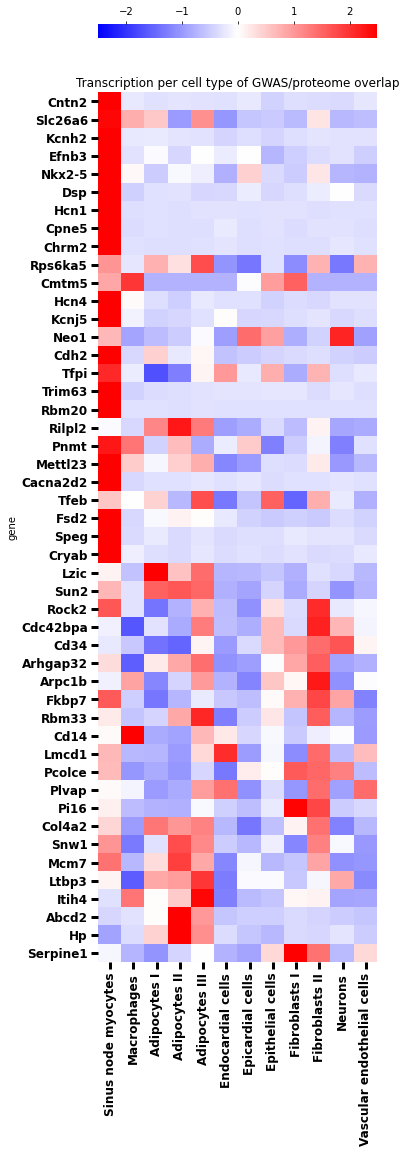

In [33]:
# plot and save heatmap of zscored snRNAseq expression values per cell type
fig, ax = plt.subplots(figsize=(5, 20))
sns.heatmap(df_transcripts_paper_overlap, cmap="bwr", ax=ax,
            xticklabels=df_transcripts_paper_overlap.columns, yticklabels=df_transcripts_paper_overlap.index, 
            vmin=-2.5, vmax=2.5, cbar_kws = dict(use_gridspec=False,location="top"))
plt.title("Transcription per cell type of GWAS/proteome overlap")
ax.tick_params(axis='both', which='major', labelsize=12, size=7, width=3)
plt.xticks(weight = 'bold')
plt.yticks(weight = 'bold')
# plt.tight_layout()

# save figure
name = "transcripts_nora_of_GWAS_overlap_proteins"
save_figure(fig, name, folder_output)
